# Quantum Hackathon

**Traffic Light Timing Optimization using QAOA**

In this notebook we study the traffic light timing optimization problem, which is NP-hard since the number of possible signal schedules grows exponentially with more intersections and phases. We formulate the problem as a QUBO/Ising Hamiltonian and use the Quantum Approximate Optimization Algorithm (QAOA) to search for good solutions. It is important to note that here we focus on the simplified case of a single junction, while also outlining how the same approach could be extended to more complex networks.

**Relation to SDGs**

Optimizing traffic light timing directly supports the United Nations Sustainable Development Goals (SDGs), especially **SDG 11: Sustainable Cities and Communities** and **SDG 13: Climate Action**.  

By improving the flow of vehicles at intersections, traffic congestion is reduced. This leads to shorter idling times, lower fuel consumption, and ultimately a **decrease in CO₂ emissions** as well as other harmful pollutants.  

Beyond the environmental impact, efficient traffic management also enhances **urban mobility**, reduces stress for commuters, and improves **road safety**.  

In this way, optimizing traffic signals contributes not only to **environmental sustainability**, but also to building **healthier, safer, and more efficient cities**.


## Setup
The libraries needed for this notebook are installed in this section, and they are pennylane and numpy

In [1]:
!pip install pennylane
!pip install numpy


[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pennylane as qml
import numpy as np

## Constructing the QUBO Objective Matrix Q

In this section, we focus on building the upper Trianglur matrix Q which encodes our constrained objective.



### Understanding the Cost Function

The cost function that we will use is
$$
  \min \left(
  -\sum_{i=1}^{n} \sum_{j=1}^{6} C_{ij} \, x_{ij}^2
  + \lambda \sum_{i} (1 - x_{ij})^2
  \right)
$$

To understand this cost function, let's first clearly define the objectives of our product:

**Maximize the cars cleared by choosing the optimal traffic light configuration $x_{ij}$ which clears $C_{ij}$ cars.**

This is a minimization problem with a minus sign.

The constraint is that we cannot choose that all traffic lights being green, to prevent accidents even though that this would model the minimum cost. So, we choose to put a penalty term and $1- x_ij ^2$. This is typical to encode one hot encoding problems since if we choose 2 terms then the penalty kicks in. We choose lambda = 60 and remain consistent with reference (1)


WE mentioned that we need to choose a traffic light configuration, reference (1) calls them modes and defines them as follows:


### Cost Function

The cost function we use is:

$$
  \min \left(
  -\sum_{i=1}^{n} \sum_{j=1}^{6} C_{ij} \, x_{ij}^2
  + \lambda \sum_{i} (1 - x_{ij})^2
  \right)
$$

---

### Understanding the Cost Function

To interpret this formulation, let us first define the main objective of our problem:

**Maximize the number of cars cleared by selecting the optimal traffic light configuration $x_{ij}$, which clears $C_{ij}$ cars.**

Since this is expressed as a minimization problem, the negative sign is used to convert the maximization into a minimization objective.

---

### Constraint and Penalty Term

A constraint arises because it is not possible (or safe) to turn all traffic lights green simultaneously. While this would mathematically minimize the cost, it would not be feasible in practice as it would cause accidents.  

To enforce this restriction, we introduce a penalty term of the form $(1 - x_{ij})^2$. This formulation is common in encoding **one-hot constraints**, ensuring that only one configuration is chosen per traffic light. If more than one configuration is selected, the penalty term is activated.

We set $\lambda = 60$, in alignment with the approach described in Reference (1), to give the penalty term sufficient weight.

---

### Modes Definition

In this context, we need to select a valid **traffic light configuration**. Reference (1) refers to these configurations as *modes* and defines them as per the following figure:


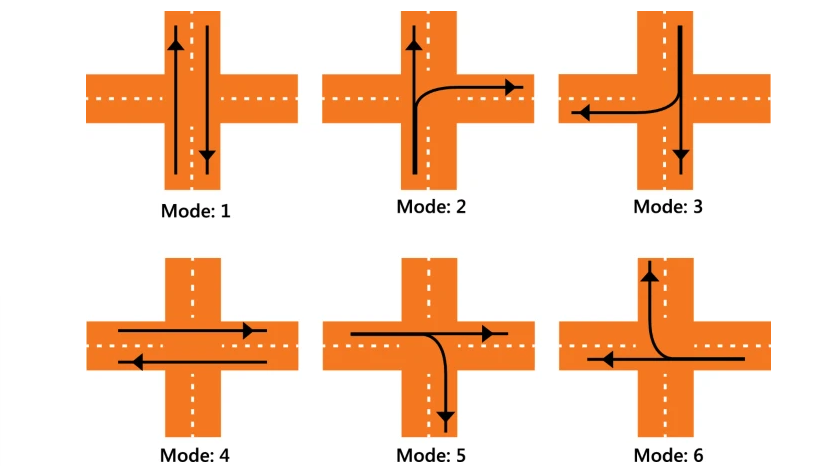

[IMAGE FROM REFERENCE 1]


Our goal is to choose the **optimal mode** that minimizes overall traffic congestion.

---

Defining Terms


To quantify the performance of each mode, we introduce two terms that allow us to define the number of cars cleared at each mode, denoted by $C_{ij}$. [1]

- **$a_{ik}$**: Represents the number of cars standing in the indicated position on any node $i$.  
- - **$f_{ik}$**: Represents the fraction of cars in lane $k$ at node $i$ that wish to continue traveling straight from their respective lane.

See the illustrations below (from Reference [1]):

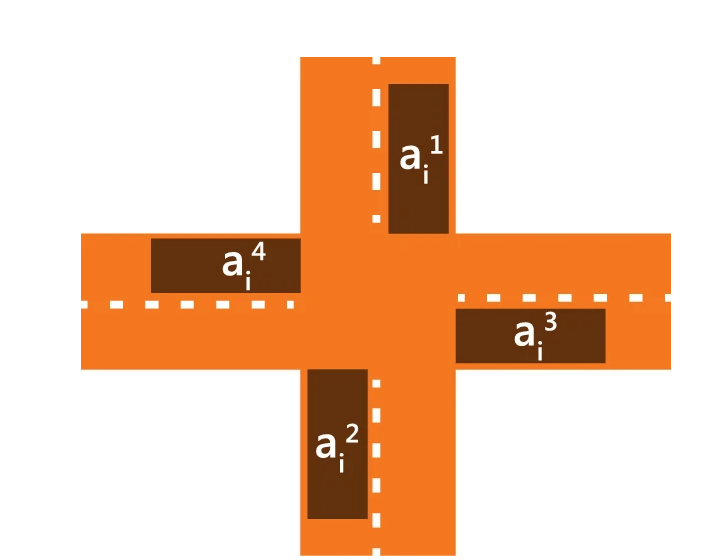

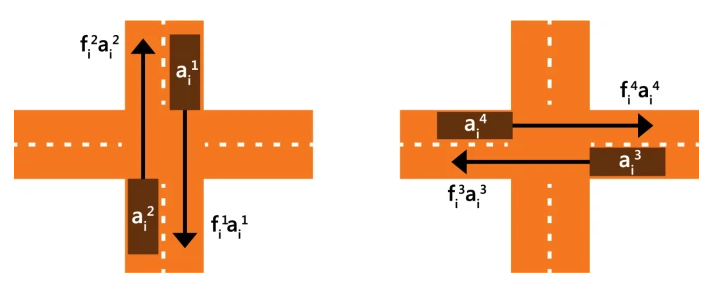

$C_{ij}$ represents the traffic cleared at node $i$ under mode $j$.  
Since we are considering a single node for now, $i$ is fixed. The expressions for each mode are:

$$
C_{i1} = f_i^1 a_i^1 + f_i^2 a_i^2
$$

$$
C_{i2} = a_i^2
$$

$$
C_{i3} = a_i^1
$$

$$
C_{i4} = f_i^3 a_i^3 + f_i^4 a_i^4
$$

$$
C_{i5} = a_i^4
$$

$$
C_{i6} = a_i^3
$$


## Implementing the cost function as a QUBO obective matrix

In [3]:
def C_ij(cost_list, f_list=(0.7,0.7,0.7,0.7)):
    coeff_list = np.zeros(6)
    coeff_list[0] = -((cost_list[0]*f_list[0]) + (cost_list[1]*f_list[1]))
    coeff_list[1] = -cost_list[0]
    coeff_list[2] = -cost_list[1]
    coeff_list[3] = -((cost_list[2]*f_list[2]) + (cost_list[3]*f_list[3]))
    coeff_list[4] = -cost_list[3]
    coeff_list[5] = -cost_list[2]
    return coeff_list

In [4]:
def objective(coeff_list):
    q1 = np.zeros((6,6))
    for i in range(len(coeff_list)):
        q1[i][i] = coeff_list[i]
    return q1

In [5]:
def constraint():
    q2 = np.zeros((6,6))
    for i in range(6):
        for j in range(i, 6):     # upper triangle only
            if i == j:
                q2[i][j] = -1
            else:
                q2[i][j] = 2
    return 60*q2

## Converting the Upper Triangular Matrix into Ising Form

In this section, we convert the QUBO formulation of our traffic-light optimization problem into an **Ising Hamiltonian**, following the approach in Reference [3].

The QUBO is expressed with binary variables $x \in \{0,1\}$, while the Ising model uses spin variables $z \in \{-1,+1\}$, which correspond to the eigenvalues of the Pauli-$Z$ operator. The mapping between the two representations is:

$$
x_i = \frac{1 - z_i}{2}
$$

Since our cost matrix $Q$ is **upper triangular**, the quadratic form is written directly as:

$$
\sum_{i \leq j} Q_{ij} x_i x_j
$$

Applying the mapping gives the equivalent Ising Hamiltonian:

$$
H = \sum_i h_i Z_i + \sum_{i<j} J_{ij} Z_i Z_j + \text{offset}.
$$

---

### Relevance to Quantum Optimization

Expressing the cost function in this Ising form makes it directly compatible with quantum optimization algorithms such as **QAOA**. Minimizing the energy of $H$ corresponds to finding the optimal traffic signal configuration.  

While **Source (1)** applies quantum annealing for minimization, our approach focuses on **QAOA**.


In [6]:
from collections import defaultdict

# from QUBO to Ising from pennylane tutorial
def from_Q_to_Ising(Q, offset):
    n_qubits = len(Q)

    h = defaultdict(int)
    J = defaultdict(int)

    for i in range(n_qubits):
        h[(i,)] -= Q[i, i] / 2
        offset += Q[i, i] / 2
        for j in range(i + 1, n_qubits):
            J[(i, j)] += Q[i, j] / 4
            h[(i,)] -= Q[i, j] / 4
            h[(j,)] -= Q[i, j] / 4
            offset += Q[i, j] / 4
    return h, J, offset


## QAOA

### Implementation of QAOA Circuit

This function builds a **parameterized QAOA circuit** that:

1. **Starts in an equal superposition**  
   Each qubit is initialized with a Hadamard gate, creating the state  
   $|+\rangle^{\otimes n}$, which is an equal superposition over all bitstrings.

2. **Applies the cost Hamiltonian (problem encoding)**  
   - Single-qubit terms $h_i Z_i$ are implemented with `qml.RZ` rotations.  
   - Two-qubit couplings $J_{ij} Z_i Z_j$ are implemented using the **CNOT–RZ–CNOT** pattern.

3. **Applies the $X$ mixer Hamiltonian (exploration)**  
   Each qubit is rotated with `qml.RX(-2 * beta)`, which corresponds to  
   $e^{-i \beta X}$. This mixes amplitudes and allows the circuit to explore different bitstrings.

4. **Repeats for $p$ layers**  
   The pair of cost and mixer unitaries is applied sequentially for each layer, using  
   the parameters $\gamma_{\text{layer}}$ and $\beta_{\text{layer}}$.

5. **Returns sampled bitstrings**  
   At the end, `qml.sample()` measures all qubits in the computational basis,  
   producing candidate solutions. With good parameter training, the optimal solution  
   appears with the highest probability.


***Parameter Initialization in QAOA***

Another important aspect is how we initialize the parameters $\beta_i$ and $\gamma_i$.  
Instead of relying on a full optimization loop, QAOA can be interpreted as a **discretized version of the quantum adiabatic algorithm**.  

- We begin in the ground state of the **mixer Hamiltonian** $X$.  
- Gradually, we move toward the ground state of the **cost Hamiltonian** $H_c$, with the pace determined by the number of layers $p$.  

By interpolating the parameters in this way—moving $\beta_i$ from **1 to 0** and $\gamma_i$ from **0 to 1**—we can directly set their values and avoid the optimization step.  

This approach is adapted from **Reference (3)**.


In [7]:
import pennylane as qml
import numpy as np

def build_qaoa_qnode(num_qubits, shots=None):
    """
    Build a PennyLane QAOA circuit that takes (gammas, betas, h, J).

    num_qubits : number of decision variables
    shots      : number of measurement shots (None = statevector)
    """
    dev = qml.device("default.qubit", wires=num_qubits, shots=shots)

    @qml.qnode(dev)
    def qaoa_circuit(gammas, betas, h, J):
        """
        QAOA ansatz for given parameters and Ising Hamiltonian.

        gammas, betas : lists of length p
        h             : dict { (i,): coeff }
        J             : dict { (i,j): coeff }
        """
        #Normalization to keep angles within reasonable range
        wmax = max(
            np.max(np.abs(list(h.values()))) if h else 0,
            np.max(np.abs(list(J.values()))) if J else 0,
            1e-12  # avoid division by zero
        )

        p = len(gammas)

        # --- Initial state: uniform superposition ---
        for i in range(num_qubits):
            qml.Hadamard(wires=i)

        # --- Apply p alternating layers ---
        for layer in range(p):
            gamma, beta = gammas[layer], betas[layer]

            # --- Cost Hamiltonian (Z and ZZ terms) ---
            for (i,), coeff in h.items():
                qml.RZ(2 * gamma * coeff, wires=i)

            for (i, j), coeff in J.items():
                qml.CNOT(wires=[i, j])
                qml.RZ(2 * gamma * coeff, wires=j)
                qml.CNOT(wires=[i, j])

            # --- Mixer Hamiltonian (X terms) ---
            for i in range(num_qubits):
                qml.RX(-2 * beta, wires=i)

        # Measurement
        return qml.sample(wires=range(num_qubits))

    return qaoa_circuit


### Helpers
This section defines some helper functions to nicely run the code



In [8]:
import numpy as np
from collections import Counter

def mode_frequencies(samples):
    """
    Convert QAOA bitstring samples (shape [shots, n_qubits])
    into mode frequencies.

    Each sample should have exactly one '1' (one-hot encoding).
    Returns a dict {mode_index: count}, with mode indices starting at 1.
    """
    if isinstance(samples, list):
        samples = np.array(samples)

    freqs = Counter()
    for bitstring in samples:
        ones = np.where(bitstring == 1)[0]
        if len(ones) == 1:  # valid one-hot
            freqs[ones[0] + 1] += 1  # shift to 1-based indexing
        # else: invalid sample (not one-hot), ignore or log it
    return dict(freqs)

def pretty_mode_results(freqs, normalize=True):
    """
    Print mode frequencies/probabilities in a nice table.
    freqs: dict {mode_index: count} (1-based indexing)
    normalize: if True, also show probabilities
    """
    freqs = {int(k): int(v) for k, v in freqs.items()}
    total = sum(freqs.values())

    print("Traffic Light Mode Results")
    print("-" * 40)
    print(f"{'Mode':<6}{'Count':<10}{'Probability' if normalize else ''}")
    print("-" * 40)

    for mode, count in sorted(freqs.items()):
        if normalize:
            prob = count / total
            print(f"{mode:<6}{count:<10}{prob:.3f}")
        else:
            print(f"{mode:<6}{count:<10}")

    print("-" * 40)
    print(f"Total shots: {total}")

def selected_mode(freqs):
    """
    Return the mode with the highest frequency (most selected mode).
    Mode indices are 1-based.
    """
    if not freqs:
        return None
    best_mode = max(freqs, key=freqs.get)
    return best_mode


## Putting it all together

Using all of the function we implemented, we run the code and determine that the output is correct

In [17]:
cost_list = (20,20,0,0)
f_list = (0.7,0.7,0.7,0.7)

In [18]:
import numpy as np

coeff = C_ij(cost_list, f_list)
a = objective(coeff)
b = constraint()
Q = a + b

print(Q)

[[-88. 120. 120. 120. 120. 120.]
 [  0. -80. 120. 120. 120. 120.]
 [  0.   0. -80. 120. 120. 120.]
 [  0.   0.   0. -60. 120. 120.]
 [  0.   0.   0.   0. -60. 120.]
 [  0.   0.   0.   0.   0. -60.]]


In [19]:
# Example: traffic light with 6 modes
n_qubits = 6

# Suppose you already have Q (6x6) from your traffic-light optimization
h, J, offset = from_Q_to_Ising(Q, offset=0.0)

# Build QAOA QNode
qaoa = build_qaoa_qnode(n_qubits, shots=5000)

# Parameters for depth p=1
betas = np.linspace(0, 1, 10)[::-1]  # Parameters for the mixer Hamiltonian
gammas = np.linspace(0, 1, 10)  # Parameters for the cost Hamiltonian

# Run circuit
samples = qaoa(gammas, betas, h, J)
print(samples[:10])   # first few sampled bitstrings


[[0 0 1 0 0 0]
 [0 1 1 0 1 1]
 [1 0 0 0 0 1]
 [1 0 0 1 0 0]
 [1 0 0 1 0 0]
 [0 0 1 0 1 1]
 [0 0 1 1 0 0]
 [0 0 1 1 1 1]
 [1 0 1 0 0 0]
 [0 1 0 0 0 0]]


In [20]:
# Run QAOA circuit with 1000 shots
samples = qaoa(gammas, betas, h, J)

# Count which modes (0–5) were chosen
freqs = mode_frequencies(samples)
pretty_mode_results(freqs)

# Normalize to probabilities
total = sum(freqs.values())
probs = {mode: count/total for mode, count in freqs.items()}
print(probs)


Traffic Light Mode Results
----------------------------------------
Mode  Count     Probability
----------------------------------------
1     203       0.297
2     148       0.217
3     154       0.225
4     67        0.098
5     51        0.075
6     60        0.088
----------------------------------------
Total shots: 683
{np.int64(6): 0.08784773060029283, np.int64(2): 0.21669106881405564, np.int64(3): 0.22547584187408493, np.int64(4): 0.09809663250366032, np.int64(1): 0.2972181551976574, np.int64(5): 0.0746705710102489}


In [21]:
best = selected_mode(freqs)
print("Selected Mode:", best)

Selected Mode: 1


This is exactly what we expect when there are 20 cars on $a_{i1}$ and $a_{i2}$ with 70% of them going straight. See below illustration:

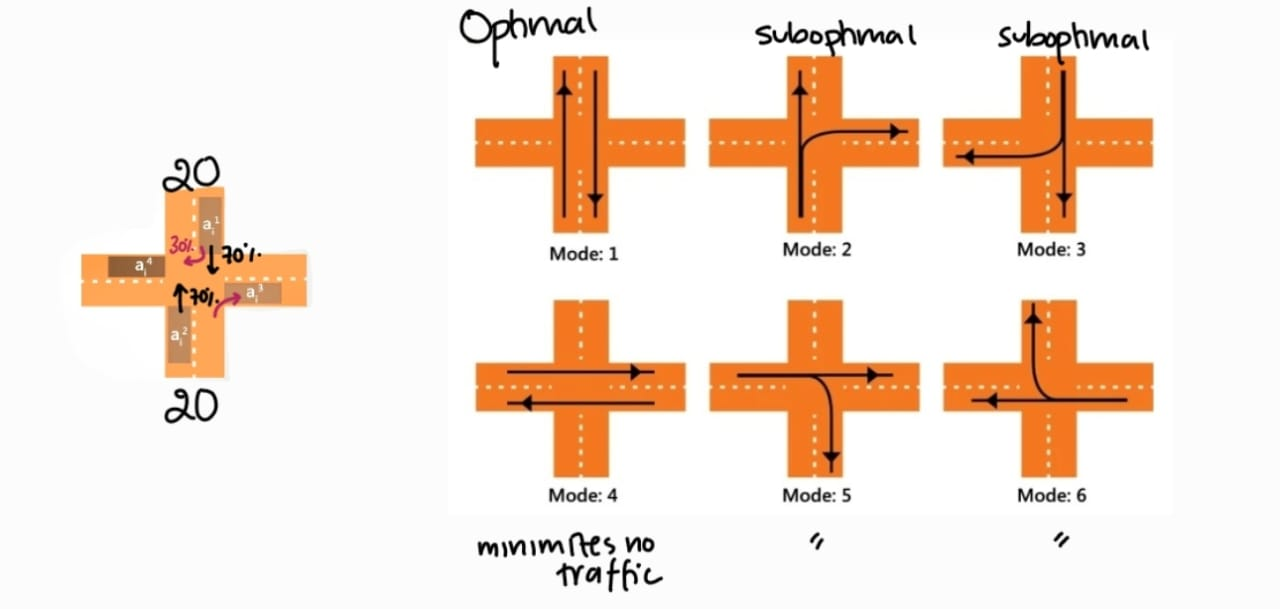

### Another Toy example

In [22]:
import numpy as np

cost_list = (1,1,20,2)
f_list = (1,1,1,1)

coeff = C_ij(cost_list, f_list)
a = objective(coeff)
b = constraint()
Q = a + b

# Example: traffic light with 6 modes
n_qubits = 6

# Suppose you already have Q (6x6) from your traffic-light optimization
h, J, offset = from_Q_to_Ising(Q, offset=0.0)

# Build QAOA QNode
qaoa = build_qaoa_qnode(n_qubits, shots=1000)

# Parameters for depth p=1
betas = np.linspace(0, 1, 10)[::-1]  # Parameters for the mixer Hamiltonian
gammas = np.linspace(0, 1, 10)  # Parameters for the cost Hamiltonian

# Run circuit
samples = qaoa(gammas, betas, h, J)

# Run QAOA circuit with 1000 shots
samples = qaoa(gammas, betas, h, J)

# Count which modes (0–5) were chosen
freqs = mode_frequencies(samples)
pretty_mode_results(freqs)

# Normalize to probabilities
total = sum(freqs.values())
probs = {mode: count/total for mode, count in freqs.items()}

best = selected_mode(freqs)
print("Selected Mode:", best)

Traffic Light Mode Results
----------------------------------------
Mode  Count     Probability
----------------------------------------
1     2         0.032
2     9         0.143
3     5         0.079
4     22        0.349
5     4         0.063
6     21        0.333
----------------------------------------
Total shots: 63
Selected Mode: 4


## A simulation

To simulate traffic flow at the intersection, we proceed as follows:

- **Car arrivals:** Cars entering the intersection are generated using a random function, and the parameter $f$ is chosen to represent the fraction of cars continuing straight.  
- **Optimization step:** The traffic-light configuration is optimized using **QAOA** every 5 seconds.  
- **Evaluation:** After each optimization step, we record the results of the algorithm to assess how effectively it clears traffic and adapts to changing conditions.

In [ ]:

import numpy as np
import random

# Number of modes (6 qubits for traffic lights)
n_qubits = 6
p = 1  # QAOA depth
random.seed(42) # adding a random seed for reproducibility

# Repeat 3 experiments
for trial in range(1, 4):
    print(f"\n===== Instance {trial} =====")

    # Step 1: Randomly generate cost_list 
    cost_list = tuple(random.randint(0, 15) for _ in range(4))   # costs between 0 and 15
    f_list = (0.8,0.8,0.8,0.8)   # fixing f for simplicity in output verification 

    print("Random cost_list:", cost_list)
    print("Random f_list:", f_list)

    # Step 2: Build Q
    coeff = C_ij(cost_list, f_list)
    a = objective(coeff)
    b = constraint()
    Q = a + b

    # Step 3: Convert QUBO to Ising
    h, J, offset = from_Q_to_Ising(Q, offset=0.0)

    # Step 4: Build QAOA circuit
    qaoa = build_qaoa_qnode(n_qubits, shots=1000)

    betas = np.linspace(0, 1, 10)[::-1]  
    gammas = np.linspace(0, 1, 10)  

    # Step 5: Run QAOA
    samples = qaoa(gammas, betas, h, J)

    # Step 6: Analyze results
    freqs = mode_frequencies(samples)
    pretty_mode_results(freqs)

    # Best mode
    best = selected_mode(freqs)
    print("Selected Mode:", best)



===== Instance 1 =====
Random cost_list: (3, 0, 8, 7)
Random f_list: (0.8, 0.8, 0.8, 0.8)
Traffic Light Mode Results
----------------------------------------
Mode  Count     Probability
----------------------------------------
1     27        0.284
2     18        0.189
3     7         0.074
4     27        0.284
5     2         0.021
6     14        0.147
----------------------------------------
Total shots: 95
Selected Mode: 4

===== Instance 2 =====
Random cost_list: (7, 4, 3, 2)
Random f_list: (0.8, 0.8, 0.8, 0.8)
Traffic Light Mode Results
----------------------------------------
Mode  Count     Probability
----------------------------------------
1     7         0.086
2     30        0.370
3     1         0.012
4     6         0.074
5     29        0.358
6     8         0.099
----------------------------------------
Total shots: 81
Selected Mode: 2

===== Instance 3 =====
Random cost_list: (13, 1, 0, 2)
Random f_list: (0.8, 0.8, 0.8, 0.8)
Traffic Light Mode Results
-------------

## Further Applications and Enhancements

To make the optimization framework more realistic and adaptable to practical traffic scenarios, we propose several extensions to the cost function:

1. **Emergency and Priority Lanes**  
   In real-world situations, certain lanes must be prioritized to allow the passage of emergency vehicles such as ambulances, fire trucks, or police cars. This can be modeled by adding **higher weights (costs)** to these lanes in the objective function. By doing so, the optimization framework ensures that configurations facilitating these priority crossings are strongly favored when such events occur.

2. **Successive Green Wave (Coordinated Intersections)**  
   Reference **[1]** highlights the importance of considering coordination across successive intersections. By including an additional term in the cost function, we can encourage **green-wave behavior**, where cars that pass through one green light are more likely to encounter another green light at the subsequent intersection. This minimizes unnecessary stops, reduces idling, and improves overall traffic flow efficiency. Such coordination significantly increases the probability that vehicles do not stop immediately after crossing the optimized intersection.

3. **Multiple Intersections and Node Interactions**  
   Traffic systems are inherently networked, with intersections influencing each other’s performance. Expanding the formulation to consider **multiple nodes** allows us to capture these interactions explicitly. By including inter-node coupling terms in the cost function, the framework accounts for downstream effects, ensuring that local optimizations (at one node) also contribute to improved performance globally across the traffic network.


## References

[1] Hussain, H., Javaid, M.B., Khan, F.S., Dalal, A. and Khalique, A. (2020). Optimal control of traffic signals using quantum annealing. Quantum Information Processing, 19(9). doi:https://doi.org/10.1007/s11128-020-02815-1.

[2] mbinjavaid (2020). GitHub - mbinjavaid/traffic_signals_qubo: Optimal control of traffic signals over time as a QUBO problem. This is the code implementation of our paper which can be found here: https://doi.org/10.1007/s11128-020-02815-1. GitHub. [online] doi:https://doi.org/10.1007/s11128-020-02815-1%3C.

[3] Montanez, A. (2024, February). *Quadratic unconstrained binary optimization*. PennyLane Demos. Xanadu. https://pennylane.ai/qml/demos/tutorial_QUBO  
